KEY: [FORD:1 , VOLKS:-1] 



first test image
prediction [-1]


 Visualization of HoG features


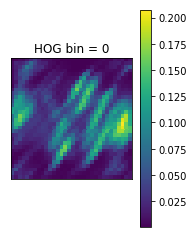

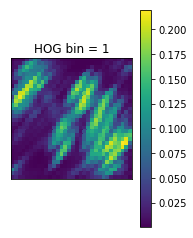

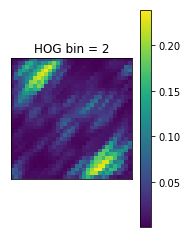

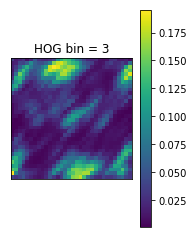

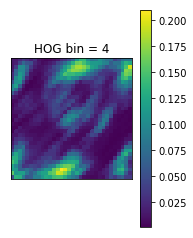

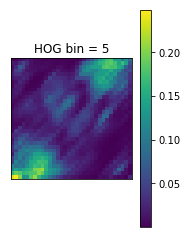

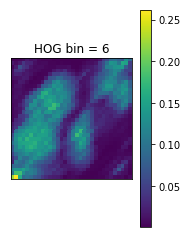

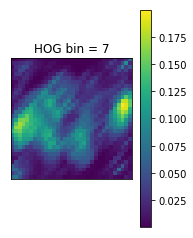




second test image
prediction [1]


 Visualization of HoG features


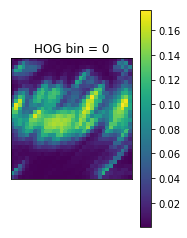

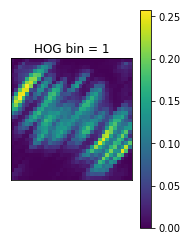

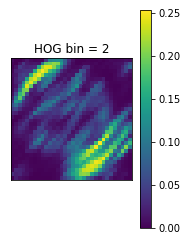

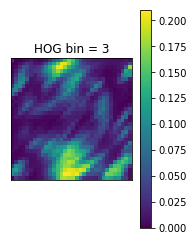

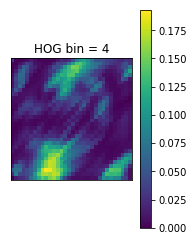

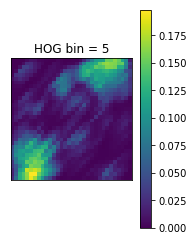

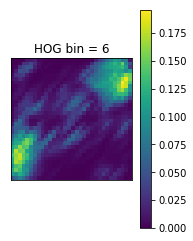

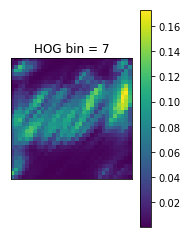

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.model_selection import  train_test_split

#list of test images
images = [0,0,0,0,0,0,0,0,0,0]
images[0] = cv2.imread('./ford_train1.jpeg')
images[1] = cv2.imread('./ford_train2.jpeg')
images[2] = cv2.imread('./ford_train3.jpeg')
images[3] = cv2.imread('./ford_train4.png')
images[4] = cv2.imread('./ford_train5.jpeg')
images[5] = cv2.imread('./volks_train1.png')
images[6] = cv2.imread('./volks_train2.jpeg')
images[7] = cv2.imread('./volks_train3.jpeg')
images[8] = cv2.imread('./volks_train4.jpeg')
images[9] = cv2.imread('./volks_train5.jpeg')

imList = []
for im in images:
    imList.append(im)


car = [] #hold name/number of maker for fitting... 1 for FORD and 0 for VOLKS

#resize images
for i in range(len(images)):
    images[i] = cv2.resize(images[i], (128, 128)) 
    if(i < 5):
        car.append(1)
    else:
        car.append(-1)

#convert to np array to be used in processing
car = np.array(car)

######################################################################################
#function to compute hog features
def hog(img):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[0], block_size[1], nbins) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
    
    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients
#end of function
######################################################################################

######################################################################################
#function to plot HoG feature
def plot_hog(gradients):
    for i in range(8):
        plt.subplot(122)
        plt.pcolor(gradients[:, :, i])
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("HOG bin = " + str(i)), plt.xticks([]), plt.yticks([])
        plt.colorbar()
        plt.show()
#end of function
######################################################################################

#list to hold the HoGs of the 10 training images
hogs = []

#calculate hog for each image
for image in images:
    grad = hog(image)
    #the classifier takes 2d training data. hog produces 3d so we flatten the result to make it 1d.. then we
    #group all hogs in one list to make a 2d list
    flat_grad = grad.flatten()
    hogs.append(flat_grad)

#convert the HoGs array to np array to be processed
hogs = np.array(hogs, 'float64')

#K Neighbors Classifier (knc)
knn = knc(n_neighbors = 3)

#split training data and targets
X_train, X_test, y_train, y_test = train_test_split(hogs, car, test_size=0.25, random_state=42)

#fit model
knn.fit(X_train, y_train)

#### TESTING ####
print('KEY: [FORD:1 , VOLKS:-1] ')
test_images = [cv2.imread('./volks_test.jpeg'), cv2.imread('./ford_test.jpeg')]

print('\n\n\n==========================================================')
for i in range(len(test_images)):
    
    if(i == 0):
        print('first test image')
    else:
        print('second test image')
    
    
    test_images[i] = cv2.resize(test_images[i], (128,128))
    grades = hog(test_images[i])
    flatHog = grades.flatten()
    
    #the predict method takes a 2d array but flatHog is 1d. 
    #so convert the array from [1 1 1] to [[1 1 1]] for example
    #8192 is the length of the flat hog
    finalHog = np.empty([1, 8192])
    for i in range(finalHog.shape[1]):
        finalHog[0][i] = flatHog[i]
    
    #predict result
    pred = knn.predict(finalHog)
    print('prediction', pred)
    print('\n\n Visualization of HoG features')
    #plot the 8 bins of each predicted image
    plot_hog(grades)
    print('\n\n\n==========================================================')


# Reasoning Questions

### 1- Quesntion 3.2.1:
HoG is not rotation invarient. However, SURF for example (or SIFT) is rotation invarient. Therefor we can find use SURF to find matches then apply a warp on the rotated image and make it the same orientation as the other images in the dataset.


### 2- Question 3.2.2: 
With one diagonal line, the change is always in one direction (i.e. normal to the line). While with two lines, we have two normals or two directions that are perpendicular to each other. 